In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
oil_prices = pd.read_csv('BrentOilPrices.csv')
oil_prices.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [3]:
oil_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8554 entries, 0 to 8553
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    8554 non-null   object 
 1   Price   8554 non-null   float64
dtypes: float64(1), object(1)
memory usage: 133.8+ KB


In [4]:
oil_prices.dtypes

Date      object
Price    float64
dtype: object

In [5]:
oil_prices.isnull().values.any()

False

In [6]:
oil_prices['Date'] = pd.to_datetime(oil_prices['Date'])
oil_prices.set_index('Date', inplace = True)

In [7]:
oil_prices.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [8]:
y = oil_prices['Price']

In [9]:
type(y)

pandas.core.series.Series

<AxesSubplot:xlabel='Date'>

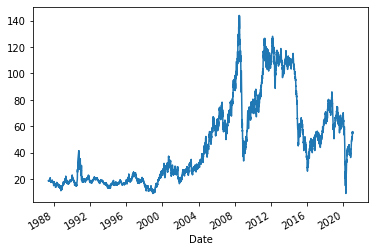

In [10]:
y.plot()

In [11]:
y.max()

143.95

In [12]:
y.min()

9.1

In [13]:
y.describe()

count    8554.000000
mean       46.352962
std        32.165282
min         9.100000
25%        18.850000
50%        33.240000
75%        66.210000
max       143.950000
Name: Price, dtype: float64

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import statsmodels.api as sm

In [15]:
y.sort_index(inplace=True)

In [16]:
period = len(y)
period

8554

In [17]:
period = period/2
period

4277.0

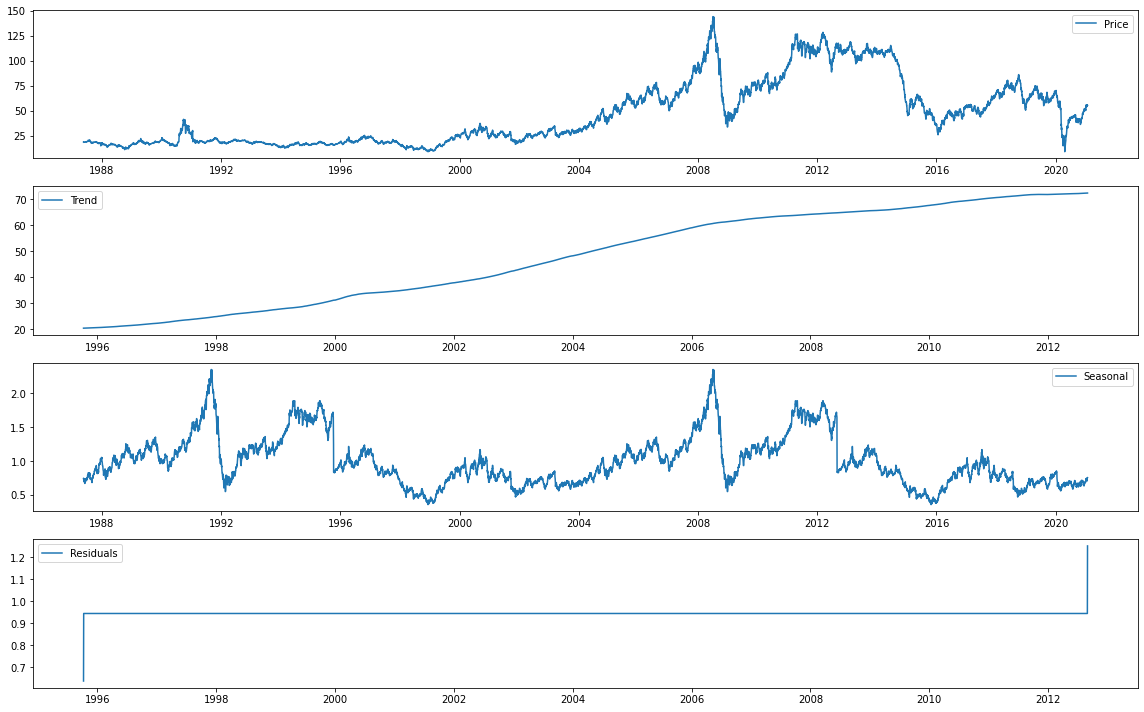

In [22]:
# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y,model='multiplicative',period=4277)

#sm.tsa.seasonal_decompose(df.asfreq('MS'), model = 'additive')

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 10))
plt.subplot(411)
plt.plot(y, label = 'Price')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout();

In [23]:
from statsmodels.tsa.stattools import kpss
kpss(y)

C:\Users\mayra\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\mayra\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


(13.616199121656487,
 0.01,
 37,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

<AxesSubplot:xlabel='Date'>

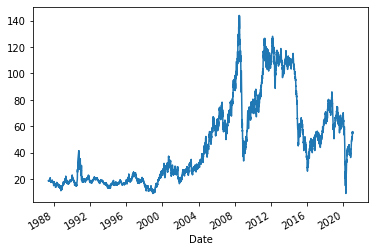

In [24]:
y.plot()

In [25]:
y_log = np.log(y)

<AxesSubplot:xlabel='Date'>

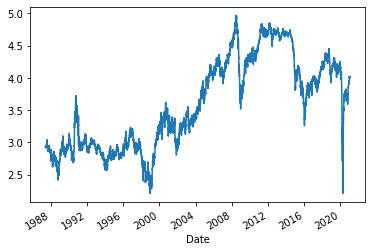

In [26]:
y_log.plot()

In [27]:
kpss(y_log.diff().dropna())

C:\Users\mayra\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\mayra\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


(0.041639703755339895,
 0.1,
 37,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [28]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [29]:
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [30]:
def arima_params(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [31]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [32]:
import warnings

warnings.filterwarnings("ignore")

arima_params(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.322
ARIMA(0, 0, 1) MSE=0.091
ARIMA(0, 1, 0) MSE=0.001
ARIMA(0, 1, 1) MSE=0.001
ARIMA(0, 1, 2) MSE=0.001
ARIMA(0, 2, 0) MSE=0.003
ARIMA(0, 2, 1) MSE=0.001
ARIMA(0, 2, 2) MSE=0.001
ARIMA(1, 0, 0) MSE=0.001
ARIMA(1, 0, 1) MSE=0.001
ARIMA(1, 0, 2) MSE=0.001
ARIMA(1, 1, 0) MSE=0.001
ARIMA(1, 1, 1) MSE=0.001
ARIMA(1, 2, 0) MSE=0.002
ARIMA(1, 2, 1) MSE=0.001
ARIMA(1, 2, 2) MSE=0.001
ARIMA(2, 0, 0) MSE=0.001
ARIMA(2, 0, 1) MSE=0.001
ARIMA(2, 1, 0) MSE=0.001
ARIMA(2, 1, 1) MSE=0.001
ARIMA(2, 1, 2) MSE=0.001
ARIMA(2, 2, 0) MSE=0.002
ARIMA(2, 2, 1) MSE=0.001
ARIMA(2, 2, 2) MSE=0.001
Best ARIMA(1, 0, 0) MSE=0.001


In [49]:
p=1
d=0
q=0
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

In [50]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 8554
Model:                     ARMA(1, 0)   Log Likelihood               19250.459
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 06 Oct 2021   AIC                         -38494.918
Time:                        20:39:09   BIC                         -38473.755
Sample:                             0   HQIC                        -38487.698
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.5643      0.340     10.478      0.000       2.898       4.231
ar.L1.Price     0.9993      0.000   2726.039      0.000       0.999       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           +0.0000j            1.0007            0.0000
-----------------------------------------------------------------------------
"""

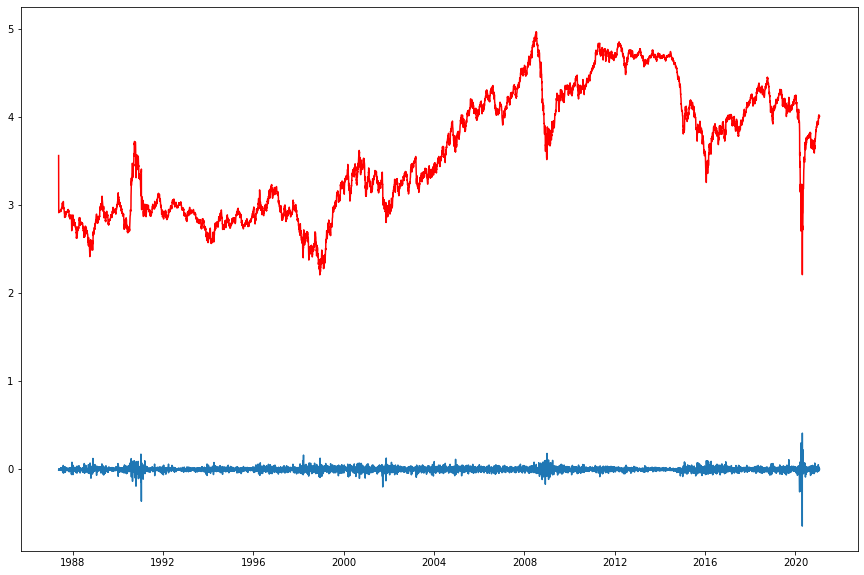

In [51]:
plt.figure(figsize=(15,10))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color = 'red')

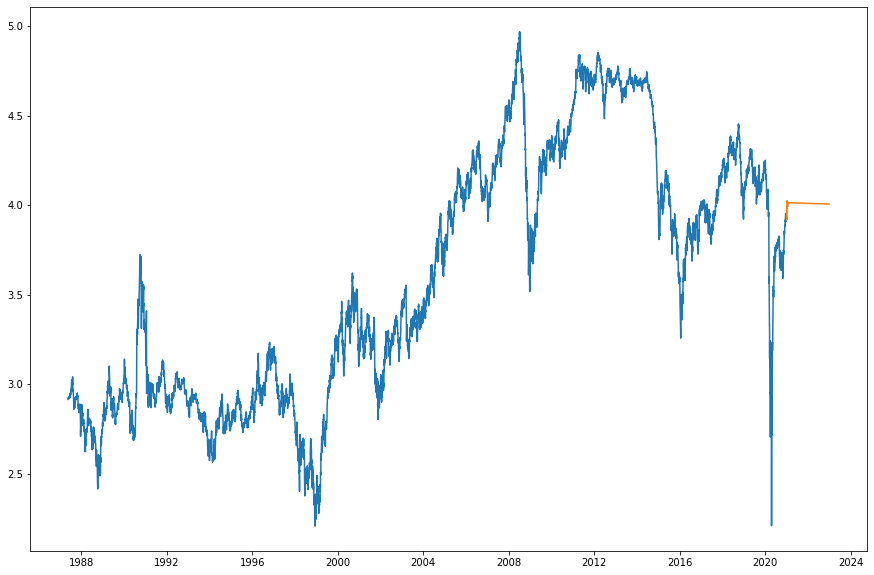

In [52]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period =  24
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y_log)
plt.plot(y_log['Jan 2021'].append(future_months['Prediction']))
plt.show()

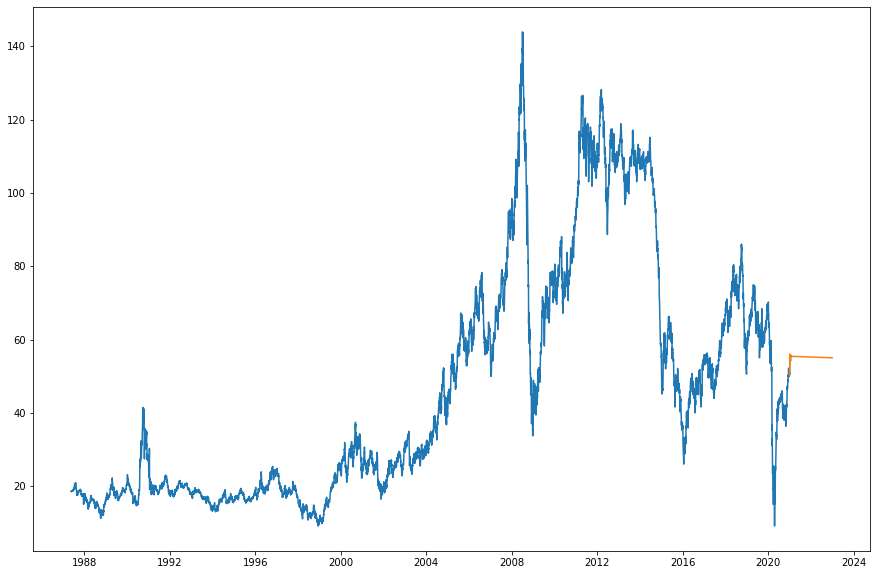

In [54]:
plt.figure(figsize=(15,10))
plt.plot(y)
plt.plot(np.exp(y_log['Jan 2021'].append(future_months['Prediction'])))
plt.show()